In [1]:

from __future__ import print_function   

import os
import numpy as np
import pylab as py


from local_minima import *
from critical_points_lines import *

import torch.nn.functional as F
from timeit import default_timer
from utilities3 import *


In [2]:

class MyNet(torch.nn.Module):
    def __init__(self, s, width=32, rank=1):
        super(MyNet, self).__init__()
        self.s = s
        self.width = width
        self.rank = rank

        self.fc0 = nn.Linear(3, self.width)

        self.net1 = LowRank2d(self.width, self.width, s, width, rank=self.rank)
        self.net2 = LowRank2d(self.width, self.width, s, width, rank=self.rank)
        self.net3 = LowRank2d(self.width, self.width, s, width, rank=self.rank)
        self.net4 = LowRank2d(self.width, self.width, s, width, rank=self.rank)
        self.w1 = nn.Linear(self.width, self.width)
        self.w2 = nn.Linear(self.width, self.width)
        self.w3 = nn.Linear(self.width, self.width)
        self.w4 = nn.Linear(self.width, self.width)

        self.bn1 = torch.nn.BatchNorm1d(self.width)
        self.bn2 = torch.nn.BatchNorm1d(self.width)
        self.bn3 = torch.nn.BatchNorm1d(self.width)
        self.bn4 = torch.nn.BatchNorm1d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)


    def forward(self, v):
        batch_size, n = v.shape[0], v.shape[1]
        a = v.clone()

        v = self.fc0(v)

        v1 = self.net1(v, a)
        v2 = self.w1(v)
        v = v1+v2
        v = self.bn1(v.reshape(-1, self.width)).view(batch_size,n,self.width)
        v = F.relu(v)

        v1 = self.net2(v, a)
        v2 = self.w2(v)
        v = v1+v2
        v = self.bn2(v.reshape(-1, self.width)).view(batch_size,n,self.width)
        v = F.relu(v)

        v1 = self.net3(v, a)
        v2 = self.w3(v)
        v = v1+v2
        v = self.bn3(v.reshape(-1, self.width)).view(batch_size,n,self.width)
        v = F.relu(v)

        v1 = self.net4(v, a)
        v2 = self.w4(v)
        v = v1+v2
        v = self.bn4(v.reshape(-1, self.width)).view(batch_size,n,self.width)


        v = self.fc1(v)
        v = F.relu(v)
        v = self.fc2(v)

        return v.squeeze()

    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c


class LowRank2d(nn.Module):
    def __init__(self, in_channels, out_channels, s, width, rank):
        super(LowRank2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.s = s
        self.n = s*s
        self.rank = rank

        self.phi = DenseNet([3, 64, 128, 256, width*width*rank], torch.nn.ReLU)
        self.psi = DenseNet([3, 64, 128, 256, width*width*rank], torch.nn.ReLU)


    def forward(self, v, a):
        # a (batch, n, 3)
        # v (batch, n, f)
        batch_size = v.shape[0]

        phi_eval = self.phi(a).reshape(batch_size, self.n, self.out_channels, self.in_channels, self.rank)
        psi_eval = self.psi(a).reshape(batch_size, self.n, self.out_channels, self.in_channels, self.rank)

        # print(psi_eval.shape, v.shape, phi_eval.shape)
        v = torch.einsum('bnoir,bni,bmoir->bmo', psi_eval, v, phi_eval) / self.n

        return v


In [3]:
TRAIN_PATH = 'piececonst_r421_N1024_smooth1.mat'
TEST_PATH = 'piececonst_r421_N1024_smooth2.mat'

ntrain = 1000
ntest = 100

batch_size = 10

r = 5
h = int(((421 - 1)/r) + 1)
s = h

reader = MatReader(TRAIN_PATH)
x_train = reader.read_field('coeff')[:ntrain,::r,::r][:,:s,:s].reshape(ntrain,s*s)
y_train = reader.read_field('sol')[:ntrain,::r,::r][:,:s,:s].reshape(ntrain,s*s)
reader.load_file(TEST_PATH)
x_test = reader.read_field('coeff')[:ntest,::r,::r][:,:s,:s].reshape(ntest,s*s)
y_test = reader.read_field('sol')[:ntest,::r,::r][:,:s,:s].reshape(ntest,s*s)


print(x_test.shape, y_test.shape)


x_normalizer = UnitGaussianNormalizer(x_test)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_test)
y_test = y_normalizer.encode(y_test)

# x_normalizer = UnitGaussianNormalizer(x_train)
# x_train = x_normalizer.encode(x_train)
# x_test = x_normalizer.encode(x_test)
# 
# y_normalizer = UnitGaussianNormalizer(y_train)
# y_train = y_normalizer.encode(y_train)
# y_test = y_normalizer.encode(y_test)


grids = []
grids.append(np.linspace(0, 1, s))
grids.append(np.linspace(0, 1, s))
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid = grid.reshape(1,s*s,2)
grid = torch.tensor(grid, dtype=torch.float)
x_test_full = torch.cat([x_test.reshape(ntest,s*s,1), grid.repeat(ntest,1,1)], dim=2)


torch.Size([100, 7225]) torch.Size([100, 7225])


In [4]:
model = torch.load('darcy2d_trained').cpu()


In [5]:
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test_full, y_test), batch_size=batch_size, shuffle=False)
x, y = next(iter(test_loader))
model_output = model(x).reshape(batch_size, s*s)



In [6]:
model_output[2].shape

torch.Size([7225])

In [7]:
X, Y = torch.meshgrid(torch.linspace(0, 1, s), torch.linspace(0, 1, s))
t_idx = 2

myloss = LpLoss(size_average=False)
loss = myloss(y[t_idx],model_output[t_idx] ) # L2 error...? 
mse = F.mse_loss(model_output[t_idx], y[t_idx], reduction='mean')

Ux = -torch.diff(y[t_idx].reshape(85, 85), dim=0, prepend=torch.zeros(1, 85)).cpu().detach().numpy()
Uy = torch.diff(y[t_idx].reshape(85, 85), dim=1, prepend=torch.zeros(85, 1)).cpu().detach().numpy()
Ux_model = -torch.diff(model_output[t_idx].reshape(85, 85), dim=0, prepend=torch.zeros(1, 85)).cpu().detach().numpy()
Uy_model = torch.diff(model_output[t_idx].reshape(85, 85), dim=1, prepend=torch.zeros(85, 1)).cpu().detach().numpy()


xdomain, ydomain = np.linspace(0, 1, s), np.linspace(0, 1, s)

N_sample = 4
xdomain, ydomain, Ux, Uy = xdomain[N_sample:-N_sample], ydomain[N_sample:-N_sample], Ux[N_sample:-N_sample, N_sample:-N_sample], Uy[N_sample:-N_sample, N_sample:-N_sample]
U = np.sqrt(Ux**2 + Uy**2)

Ux_model, Uy_model = Ux_model[N_sample:-N_sample, N_sample:-N_sample], Uy_model[N_sample:-N_sample, N_sample:-N_sample]
Umodel = np.sqrt(Ux_model**2 + Uy_model**2)


Navg_x = 20 #12  # number of points taken when calculating local average (one sided along x direction)
Navg_y = 20 #12  # number of points taken when calculating local average (one sided along y direction)
Npoints_th = 0.25
th_thin = 0.1  # Thereshold for thinning critical points (i.e. two points with Euclidean dist < th_thin are counted only once)

print(U.shape, xdomain.shape)

ind_1 = adj_local_minima(xdomain,ydomain,U)                   # Find indices of the local minimas. Correct for corner points
# print(ind_1)
c_type = critical_point_type(xdomain, ydomain, Ux, Uy, ind_1)
# ind_2 = ind_1
ind_2 = thin_local_minima(xdomain,ydomain,ind_1,th_thin)    # Ignore points that are close to each other (select only one)
avF = avgF_at_local_minima(U,ind_2,Navg_x,Navg_y)            # Calculate local averages
# ind_sort = np.flip(np.argsort(avF))                         # sort from maximum average value to minimum average value
ind_sort = np.argsort(avF)                                   # sort from minimum average value to maximum average value
Npoints = Npoint_estimate(avF[ind_sort], Npoints_th,1)       # Estimate the number of critical points
ind_3 = adj_with_rank(ind_2, ind_sort, Npoints)              # Clip to the estimated number of critical points
ind_adj = ind_3                       # Local average raknin algorithm needs more work. It is skipped for now

print(ind_adj)
# py.streamplot(xdomain, ydomain, Ux, Uy, color=U)

# stream_lines(xdomain,ydomain,Ux,Uy,ind_adj)


(77, 77) (77,)
m = 0, ratio = 1.000, flag = 0 

m = 1, ratio = 1.581, flag = 0 

m = 2, ratio = 1.800, flag = 0 

m = 3, ratio = 1.949, flag = 0 

m = 4, ratio = 2.331, flag = 0 

m = 5, ratio = 3.033, flag = 0 

(array([75, 75, 43, 72,  8, 43]), array([24, 38, 11, 74, 34, 34]))


/home/ai/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:

ind_1_model = adj_local_minima(xdomain,ydomain,Umodel)                   # Find indices of the local minimas. Correct for corner points
# print(ind_1)
c_type_model = critical_point_type(xdomain, ydomain, Ux_model, Uy_model, ind_1_model)
# ind_2 = ind_1
ind_2_model = thin_local_minima(xdomain,ydomain,ind_1_model,th_thin)    # Ignore points that are close to each other (select only one)
avF_model = avgF_at_local_minima(Umodel,ind_2_model,Navg_x,Navg_y)            # Calculate local averages
# ind_sort = np.flip(np.argsort(avF))                         # sort from maximum average value to minimum average value
ind_sort_model = np.argsort(avF_model)                                   # sort from minimum average value to maximum average value
Npoints = Npoint_estimate(avF_model[ind_sort_model], Npoints_th,1)       # Estimate the number of critical points
ind_3_model = adj_with_rank(ind_2_model, ind_sort_model, Npoints)              # Clip to the estimated number of critical points
ind_adj_model = ind_3_model                      # Local average raknin algorithm needs more work. It is skipped for now

print(ind_adj_model)
# py.streamplot(

m = 0, ratio = 1.000, flag = 0 

m = 1, ratio = 1.452, flag = 0 

m = 2, ratio = 1.472, flag = 0 

(array([75, 75, 75]), array([14, 66, 44]))


Text(0.5, 1.0, '2D Darcy Flow\n$ \\begin{cases}- \\nabla \\cdot (a(x) \\nabla u(x)) &= 1 \\quad x \\in (0, 1)^2 \\\\ u(x) &= 0 \\quad \\quad x \\in \\partial (0, 1)^2 \\end{cases}$\nPrediction MSE: 0.0868\n')

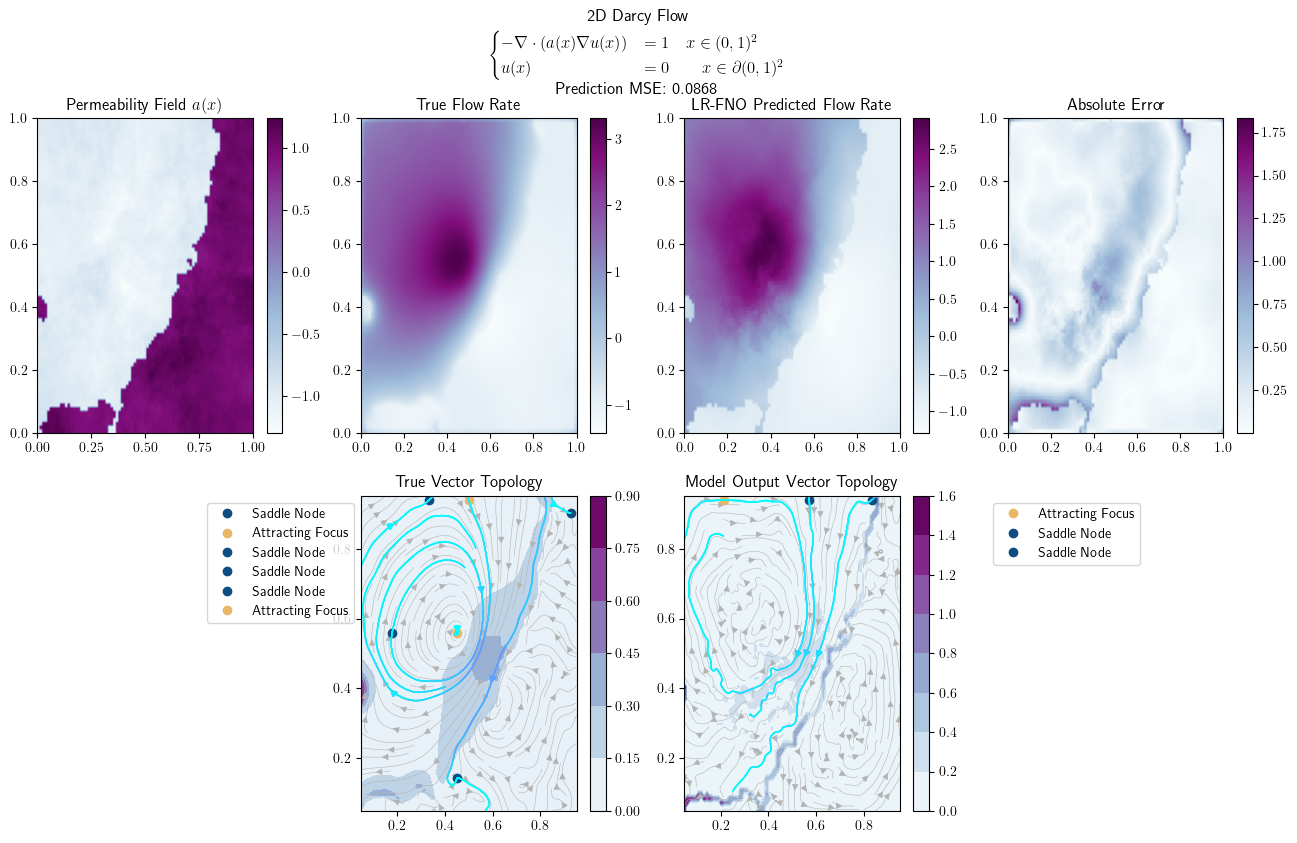

In [9]:
py.figure(figsize=(16, 9)) 

py.rc('text', usetex=True)
py.rc('text.latex', preamble=r'\usepackage{amsmath}')


py.subplot(241)

py.imshow(x[t_idx, :, 0].reshape(85, 85).flip(0).cpu().numpy(), aspect='auto', cmap='BuPu', extent=[0, 1, 0, 1])
py.colorbar()
py.xticks(np.linspace(0, 1, 5))
py.xticks(np.linspace(0, 1, 5))
py.title("Permeability Field" + r" $a(x)$")

py.subplot(242)
py.imshow(y[t_idx].reshape(85, 85).flip(0).cpu().numpy(), aspect='auto', cmap='BuPu', extent=[0, 1, 0, 1])
py.colorbar()
# py.contourf(xdomain, ydomain, y[t_idx].reshape(85, 85).cpu().numpy())
py.title("True Flow Rate")

py.subplot(243) 
py.imshow(model_output[t_idx].reshape(85, 85).flip(0).cpu().detach().numpy(), aspect='auto', cmap='BuPu', extent=[0,1,0,1])
py.colorbar()
# py.contourf(xdomain, ydomain, y[t_idx].reshape(85, 85).cpu().numpy())
py.title("LR-FNO Predicted Flow Rate")

py.subplot(244) 

py.imshow(np.abs(y[t_idx].reshape(85, 85).flip(0).cpu().numpy()- model_output[t_idx].reshape(85, 85).flip(0).cpu().detach().numpy()), aspect='auto', cmap='BuPu', extent=[0, 1, 0, 1])
py.colorbar()
# py.contourf(xdomain, ydomain, y[t_idx].reshape(85, 85).cpu().numpy())
py.title("Absolute Error")



py.subplot(246)
py.contourf(xdomain, ydomain, U, cmap='BuPu')
# py.imshow(U, aspect='auto')
# py.imshow(U)
py.colorbar()

py.streamplot(xdomain, ydomain, Ux, Uy,color = [.7, .7 , .7],density = 1.2, linewidth = 0.4)
stream_lines(xdomain,ydomain,Ux,Uy,ind_adj, cmap='cool')
py.legend(bbox_to_anchor=(0., 1.),)
py.title("True Vector Topology")

py.subplot(247)
py.contourf(xdomain, ydomain, Umodel, cmap='BuPu')
# py.imshow(U, aspect='auto')
# py.imshow(U)
py.colorbar()

py.streamplot(xdomain, ydomain, Ux_model , Uy_model ,color = [.7, .7 , .7],density = 1.2, linewidth = 0.4)
stream_lines(xdomain,ydomain,Ux_model ,Uy_model ,ind_adj_model , cmap='cool')
py.legend(bbox_to_anchor=(1.4, 1.),)
py.title("Model Output Vector Topology")
py.xlim(np.min(xdomain), np.max(xdomain))

py.suptitle("2D Darcy Flow" + '\n' + r"$ \begin{cases}- \nabla \cdot (a(x) \nabla u(x)) &= 1 \quad x \in (0, 1)^2 \\ u(x) &= 0 \quad \quad x \in \partial (0, 1)^2 \end{cases}$" + '\n' + f"Prediction MSE: {mse.item():.4f}" + '\n', y=1.)

Text(0.5, 1.0, '2D Darcy Flow\n$ \\begin{cases}- \\nabla \\cdot (a(x) \\nabla u(x)) &= 1 \\quad x \\in (0, 1)^2 \\\\ u(x) &= 0 \\quad \\quad x \\in \\partial (0, 1)^2 \\end{cases}$\nPrediction MSE: 0.0868\n')

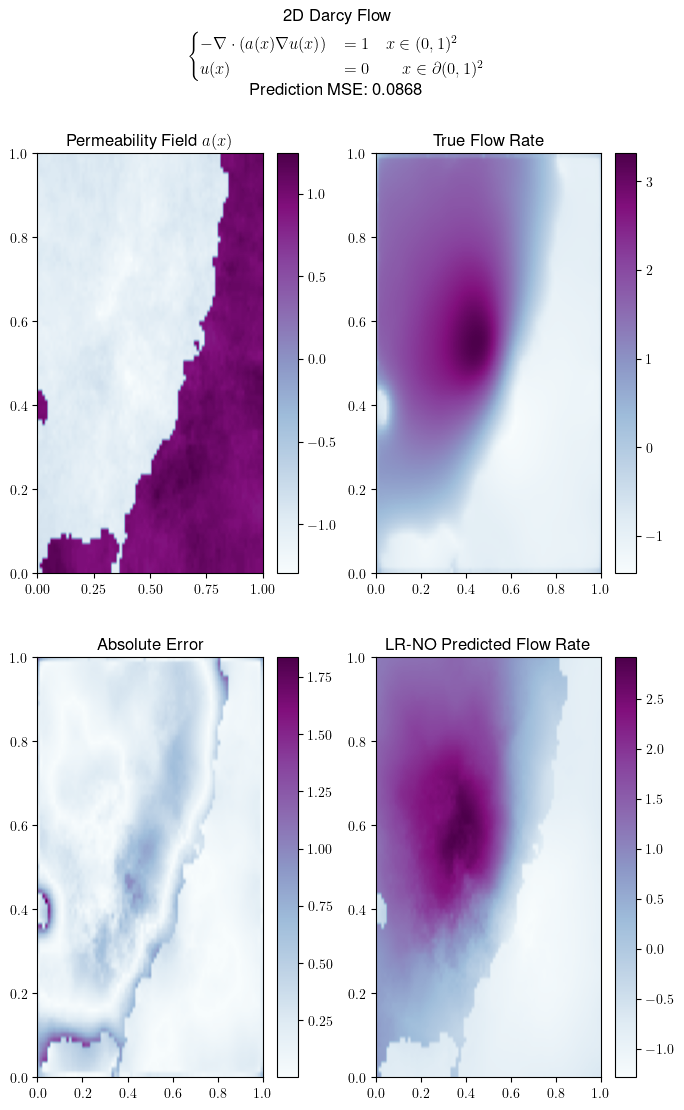

In [32]:
py.figure(figsize=(8, 12)) 

py.rc('text', usetex=True)
py.rc('text.latex', preamble=r'\usepackage{amsmath}')

py.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

py.subplot(221)

py.imshow(x[t_idx, :, 0].reshape(85, 85).flip(0).cpu().numpy(), aspect='auto', cmap='BuPu', extent=[0, 1, 0, 1])
py.colorbar()
py.xticks(np.linspace(0, 1, 5))
py.xticks(np.linspace(0, 1, 5))
py.title("Permeability Field" + r" $a(x)$")

py.subplot(222)
py.imshow(y[t_idx].reshape(85, 85).flip(0).cpu().numpy(), aspect='auto', cmap='BuPu', extent=[0, 1, 0, 1])
py.colorbar()
# py.contourf(xdomain, ydomain, y[t_idx].reshape(85, 85).cpu().numpy())
py.title("True Flow Rate")

py.subplot(224) 
py.imshow(model_output[t_idx].reshape(85, 85).flip(0).cpu().detach().numpy(), aspect='auto', cmap='BuPu', extent=[0,1,0,1])
py.colorbar()
# py.contourf(xdomain, ydomain, y[t_idx].reshape(85, 85).cpu().numpy())
py.title("LR-NO Predicted Flow Rate")

py.subplot(223) 

py.imshow(np.abs(y[t_idx].reshape(85, 85).flip(0).cpu().numpy()- model_output[t_idx].reshape(85, 85).flip(0).cpu().detach().numpy()), aspect='auto', cmap='BuPu', extent=[0, 1, 0, 1])
py.colorbar()
# py.contourf(xdomain, ydomain, y[t_idx].reshape(85, 85).cpu().numpy())
py.title("Absolute Error")

py.suptitle("2D Darcy Flow" + '\n' + r"$ \begin{cases}- \nabla \cdot (a(x) \nabla u(x)) &= 1 \quad x \in (0, 1)^2 \\ u(x) &= 0 \quad \quad x \in \partial (0, 1)^2 \end{cases}$" + '\n' + f"Prediction MSE: {mse.item():.4f}" + '\n', y=1.)


(0.047619047619047616, 0.9523809523809523)

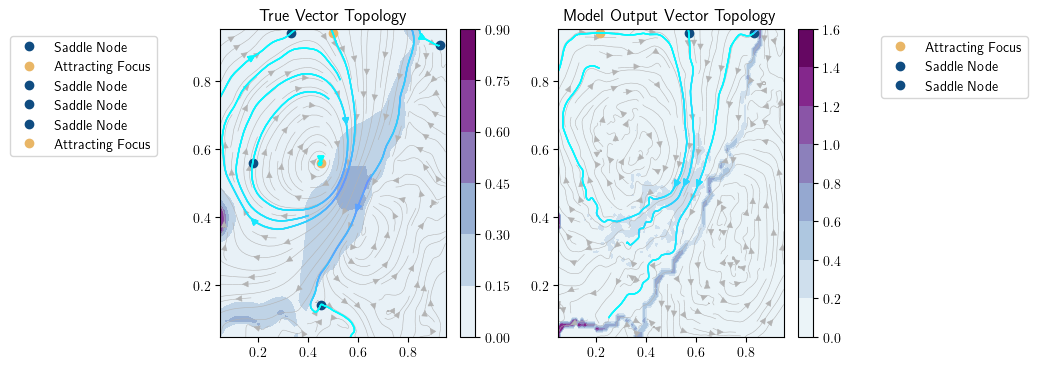

In [10]:

py.figure(figsize=(8, 4))
py.subplot(121)

py.contourf(xdomain, ydomain, U, cmap='BuPu')
# py.imshow(U, aspect='auto')
# py.imshow(U)
py.colorbar()

py.streamplot(xdomain, ydomain, Ux, Uy,color = [.7, .7 , .7],density = 1.2, linewidth = 0.4)
stream_lines(xdomain,ydomain,Ux,Uy,ind_adj, cmap='cool')
py.legend(bbox_to_anchor=(-0.25, 1.),)
py.title("True Vector Topology")

py.subplot(122)
py.contourf(xdomain, ydomain, Umodel, cmap='BuPu')
# py.imshow(U, aspect='auto')
# py.imshow(U)
py.colorbar()

py.streamplot(xdomain, ydomain, Ux_model , Uy_model ,color = [.7, .7 , .7],density = 1.2, linewidth = 0.4)
stream_lines(xdomain,ydomain,Ux_model ,Uy_model ,ind_adj_model , cmap='cool')
py.legend(bbox_to_anchor=(1.4, 1.),)
py.title("Model Output Vector Topology")
py.xlim(np.min(xdomain), np.max(xdomain))

In [11]:
Ux.shape, Ux_model.shape

((77, 77), (77, 77))